In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import OneHotEncoder

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
import tensorflow as tf
from tensorflow import keras

from IPython.display import clear_output

In [13]:
class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def __init__(self, metrics=[]):
        self.print_metrics = metrics
        print("HEEEERE", metrics)

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(len(metrics)//2 +1 , 2, figsize=(20,10))
        
        clear_output(wait=True)
        axs = list(np.array(axs).flatten())

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric],
                        label=metric)
            
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)

            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([min(min(history.history['loss']), min(history.history['loss']))*0.8, max(max(history.history['loss']), max(history.history['loss']))*1.1])
    plt.xlabel('Epoch')
    plt.ylabel('Error [monthly spend]')
    plt.legend()
    plt.grid(True)

In [14]:
dataset = pd.read_json('train_data.json')
dataset = dataset.drop(columns = ['monthly_spend', 'profit', 'time_as_client'])

target = 'compliant'

# now we have an estimator for the clients monthly spend and we can use it as a feature
m_spend_model = tf.keras.models.load_model('m_spend_regressor.dnn')
m_spend_data = dataset.copy().drop(target,axis=1)

dataset['est_monthly_spend'] = m_spend_model.predict(m_spend_data).flatten()

257/257 [==============================] - 0s 877us/step


In [15]:
train_dataset = dataset.sample(frac=0.9, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [16]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

features = test_features.columns.drop(target)

train_labels = train_features.pop(target)
test_labels = test_features.pop(target)

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

In [17]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(16, activation="tanh"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(8, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid")
    ])

    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(1e-3,
                                                                 decay_steps = 1000,
                                                                 decay_rate=10,
                                                                 staircase=False)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
                  loss="binary_crossentropy", metrics=[tf.keras.metrics.Precision(),
                                                       tf.keras.metrics.Recall(),
                                                       tf.keras.metrics.FalseNegatives(),
                                                       tf.keras.metrics.FalsePositives(),
                                                       tf.keras.metrics.TrueNegatives(),
                                                       tf.keras.metrics.TruePositives()])
    model.save_weights('initial_compliant_model.h5')
    
    return model

In [18]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 22)               45        
 ion)                                                            
                                                                 
 dense_4 (Dense)             (None, 32)                736       
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 8)                 136       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                      

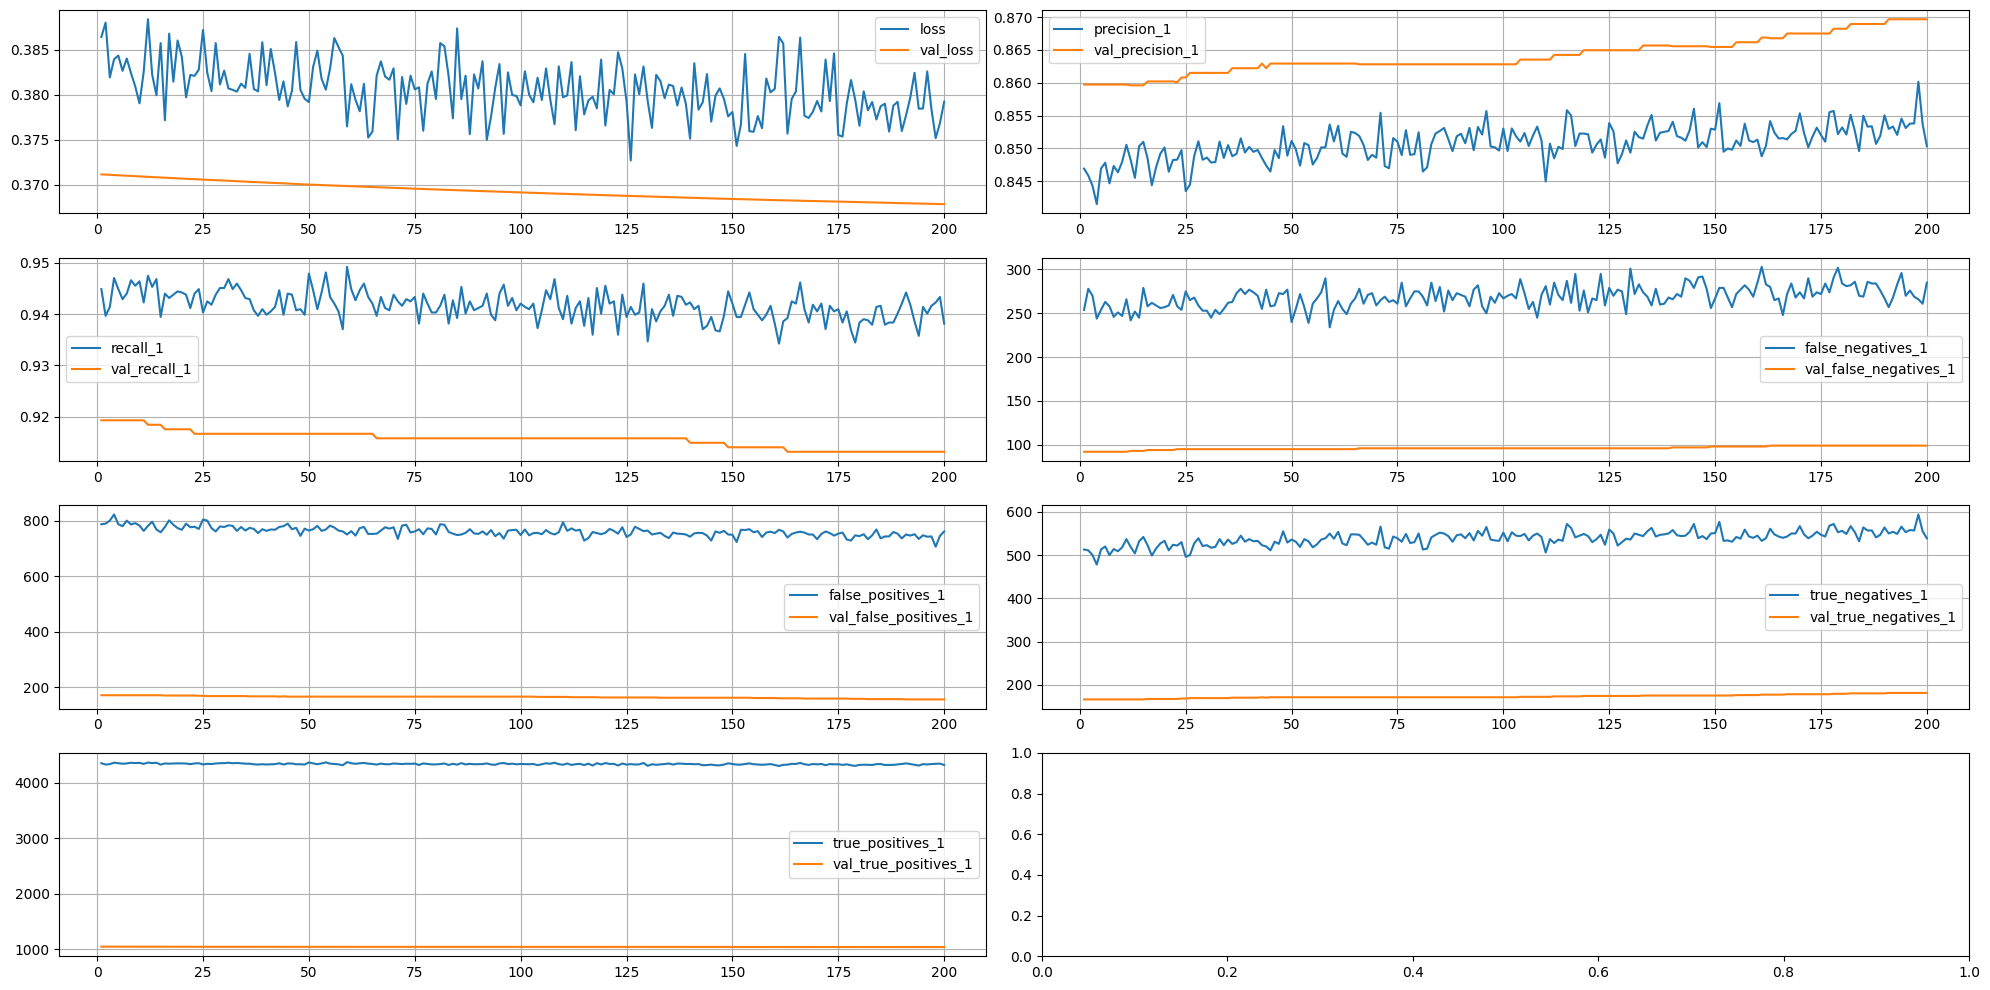

185/185 [==============================] - 1s 7ms/step - loss: 0.3792 - precision_1: 0.8503 - recall_1: 0.9382 - false_negatives_1: 285.0000 - false_positives_1: 761.0000 - true_negatives_1: 539.0000 - true_positives_1: 4323.0000 - val_loss: 0.3678 - val_precision_1: 0.8697 - val_recall_1: 0.9132 - val_false_negatives_1: 99.0000 - val_false_positives_1: 156.0000 - val_true_negatives_1: 181.0000 - val_true_positives_1: 1041.0000
CPU times: user 5min 13s, sys: 1min 10s, total: 6min 24s
Wall time: 4min 21s


In [35]:
%%time

metrics_to_plot = ['loss', 'precision', 'recall', 'true_positives']

callbacks_list = [PlotLearning(metrics_to_plot),
                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                   verbose=1,
                                                   min_delta=1e-4,
                                                   patience=25,
                                                   restore_best_weights=True)]

# dnn_model.load_weights('initial_compliant_model.h5')
history = dnn_model.fit(train_features, 
                        train_labels, 
                        validation_split=0.2,
                        verbose=1, 
                        epochs=200,
                        callbacks=callbacks_list)

In [ ]:
dnn_model.evaluate(test_features, test_labels, verbose=1)

test_predictions = dnn_model.predict(test_features).flatten()
test_predictions

In [32]:
dnn_model.metrics

In [33]:
FN = dnn_model.metrics[-4].result().numpy()
FP = dnn_model.metrics[-3].result().numpy()
TN = dnn_model.metrics[-2].result().numpy() 
TP = dnn_model.metrics[-1].result().numpy()
print("TP", TP)

T = FN + FP + TN + TP
T

TP 1048.0


1477.0

In [34]:
TP/(TP+FP)

0.85972106

In [23]:
tp_profit = TP * 1010.234425 * 91 * 0.02
tp_profit

1915848.972947

In [36]:
dnn_model.save('compliant_classifier.dnn')

INFO:tensorflow:Assets written to: compliant_classifier.dnn/assets


INFO:tensorflow:Assets written to: compliant_classifier.dnn/assets


In [ ]:
original_test_dataset = pd.read_json('test_data_month_pred.json')
original_test_dataset = original_test_dataset.rename(columns={'predicted_monthly_spend':'est_monthly_spend'})



In [ ]:
test_dataset_features = original_test_dataset[features]
test_dataset_target = original_test_dataset[[target]].copy()
test_dataset_target

In [62]:
predictions = dnn_model.predict(test_dataset_features).flatten()
predictions = [int(np.round(i,0)) for i in predictions]
original_test_dataset['predictions'] = predictions
original_test_dataset[[target, 'predictions']]

approved_clients = original_test_dataset[original_test_dataset.predictions == 1].copy()
approved_clients['profit'] = (approved_clients['time_as_client']*approved_clients['monthly_spend']*0.02 - (1-approved_clients['compliant'])*approved_clients['monthly_spend'])


# original_test_dataset['profit'] = (clients_data['time_as_client']*clients_data['monthly_spend']*0.02 - clients_data['defaulted']*clients_data['monthly_spend'])

# original_test_dataset['predicted_compliant'] = predictions

32/32 [==============================] - 0s 870us/step
total_profit_per_client 1529.6566913580245


In [67]:
original_test_dataset['profit'] = (original_test_dataset['time_as_client']*original_test_dataset['monthly_spend']*0.02 - (1-original_test_dataset['compliant'])*original_test_dataset['monthly_spend'])

total_profit_per_client = approved_clients['profit'].mean()
original_profit_per_client = original_test_dataset['profit'].mean()

print(f'Original profit_per_client = {original_profit_per_client:.2f}')
print(f'After model profit_per_client = {total_profit_per_client:.2f}')
print(f'Improvement: {(total_profit_per_client-original_profit_per_client)*100/(original_profit_per_client):.2f}%')


Original profit_per_client = 1290.92
After model profit_per_client = 1529.66
Improvement: 18.49%
